## Loading detector systematics
An example to demonstrate how detector systematics are loaded into the RunHistGenerator.

From the PELEE directory, the detector systematics data is generated using the `make_detsys.py` script as follows: 
```
python make_detsys.py --run 1 --selection NPBDT --preselection NP --output-file sandbox/atrettin/detsys_run1_nue_npbdt.json --binning-def "reco_e, 10, 0.15, 1.55"
```

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append("../../")
import data_loading as dl

In [3]:
from microfit.histogram import Binning, Histogram, HistogramGenerator, RunHistGenerator

data_pot = 1.0e20
# The query strings for the selection are defined in the `selections.py` file.
selection = "NPBDT"
preselection = "NP"
# Binnings are defined by the variable to be binned, the number of bins, and the range, and the label.
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")
binning = Binning.from_config(*binning_def)
# The binning is a class with a defined repr:
binning

Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False, selection_query=None)

In [4]:
from microfit.run_plotter import RunHistPlotter

RUN = ["1"]
all_truth_filters = [
    "nue",
    "drt",
    # remove the ones below to save some time
    # "nc_pi0",
    # "cc_pi0",
    # "cc_nopi",
    # "cc_cpi",
    # "nc_nopi",
    # "nc_cpi",
]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    truth_filtered_sets=all_truth_filters,
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=False,
    enable_cache=True,
)

signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
    detvar_data_path="detsys_run1_nue_npbdt.json",
)
plotter = RunHistPlotter(signal_generator, selection_title=None)
plotter.title = plotter.get_selection_title(selection=selection, preselection=preselection)

Text(0.5, 1.0, 'Detector Covariance, Run1, 1eNp Presel. and 1eNp BDT sel.')

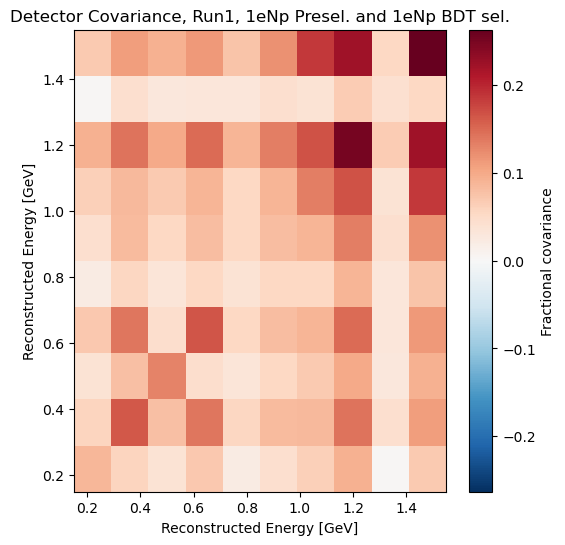

In [5]:
from matplotlib import pyplot as plt

tmp_histogram = signal_generator.get_mc_hist()
cov_mat_total= signal_generator.mc_hist_generator.calculate_detector_covariance()
tmp_histogram.covariance_matrix = cov_mat_total
fig, ax = plt.subplots(figsize=(6, 6))
tmp_histogram.draw_covariance_matrix(as_correlation=False, as_fractional=True, ax=ax)
ax.set_title(f"Detector Covariance, Run1, {plotter.title}")
# fig.savefig("detector_correlation_run1.pdf")

In [6]:
import logging

logging.basicConfig(level=logging.WARNING)

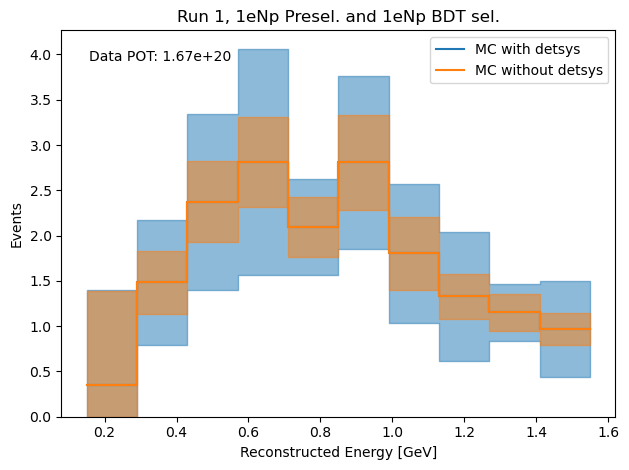

In [7]:
from matplotlib import pyplot as plt


hist_with_detsys = signal_generator.mc_hist_generator.generate(include_multisim_errors=True, add_precomputed_detsys=True)
hist_without_detsys = signal_generator.mc_hist_generator.generate(include_multisim_errors=True, add_precomputed_detsys=False)

fig, ax = plt.subplots()
hist_with_detsys.draw(ax=ax, label="MC with detsys")
hist_without_detsys.draw(ax=ax, label="MC without detsys")
ax.legend()
ax.set_xlabel(binning.label)
ax.set_ylim(bottom=0)  # set the minimum value of y axis to 0
ax.set_title("Run 1, "+ plotter.title)
pot_text = f"Data POT: {data_pot}"
plt.text(0.05, 0.95, pot_text, transform=ax.transAxes, ha='left', va='top')
fig.tight_layout()

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

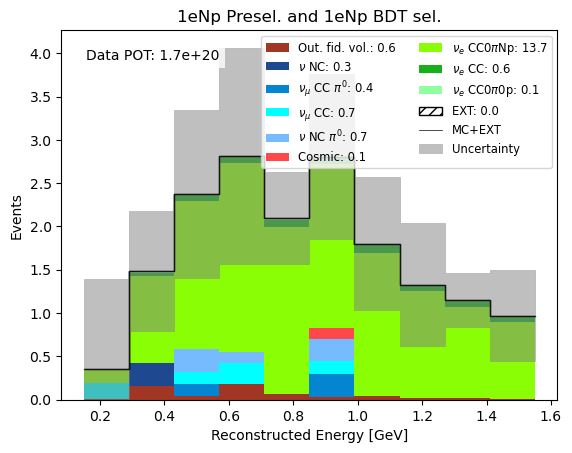

In [8]:
plotter.plot(add_ext_error_floor=False, category_column="category", include_multisim_errors=True, add_precomputed_detsys=True)

In [9]:
signal_generator2 = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
    detvar_data_path="detsys_run1_nue_npbdt.json",
)

Text(0.5, 1.0, 'Detector Covariance, Run1, 1eNp Presel. and 1eNp BDT sel.')

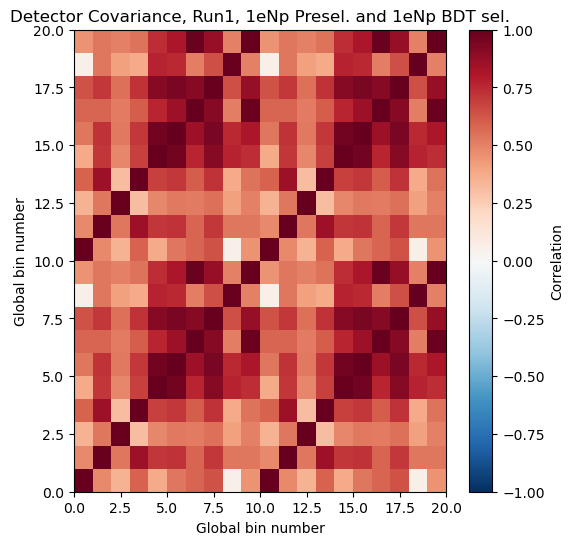

In [10]:
import numpy as np
from microfit.histogram import HistogramGenerator, Histogram, Binning, MultiChannelBinning, MultiChannelHistogram

hist_gen_1 = signal_generator.mc_hist_generator
hist_gen_2 = signal_generator2.mc_hist_generator

combined_covariance = HistogramGenerator.multiband_detector_covariance([hist_gen_1, hist_gen_2])

combined_binning = MultiChannelBinning([hist_gen_1.binning, hist_gen_2.binning])
hist_1 = hist_gen_1.generate()
hist_2 = hist_gen_2.generate()
concatenated_bin_counts = np.concatenate([hist_1.nominal_values, hist_2.nominal_values])
# plot covariance using a temporary histogram object as we did above
fig, ax = plt.subplots(figsize=(6, 6))
tmp_histogram = MultiChannelHistogram(combined_binning, concatenated_bin_counts, covariance_matrix=combined_covariance)
tmp_histogram.draw_covariance_matrix(as_correlation=True, as_fractional=False, ax=ax)
ax.set_title(f"Detector Covariance, Run1, {plotter.title}")


In [16]:
RUN = ["1"]

rundata_numu, mc_weights_numu, data_pot_numu = dl.load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue", "drt"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    numupresel=True,
    loadnumuvariables=True,
    load_crt_vars=False,
    blinded=False,  # sideband needs to be unblinded to work
)

/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
rundata_numu["mc"]

,theta,weightSpline,ccnc,_opfilter_pe_veto,isVtxInFiducial,mc_pz,true_nu_vtx_x,pi0truth_elec_etot,trk_dir_z_v,knobThetaDelta2Npidn,...,n_showers_tot,is_signal,paper_category,paper_category_xsec,paper_category_numu,category_1e1p,dataset,weights,weights_no_tune,dataset_name
entry,,,,,,,,,,,,,,,,,,,,,
0,0.320585,1.010967,0,0.000000,True,"[0.68661225, -0.14003249, 0.030513335, -0.1023...",58.057987,0.000000,"[0.9513575, 0.7058697]",1.261103,...,0,False,2,2,2,12,mc,0.045222,0.035859,mc
1,1.005514,1.000000,0,0.000000,True,"[0.20644265, 0.6755108, 0.14538588]",187.905121,26.569546,"[0.5322803, 0.6761439]",1.000000,...,0,False,2,2,2,2,mc,0.035470,0.035470,mc
2,0.274902,1.005340,0,0.000000,True,"[0.6999858, -0.23114012, 0.027456902, -0.10919...",186.461090,12.329539,[0.96658003],1.076352,...,0,False,2,2,2,2,mc,0.038382,0.035659,mc
3,0.190343,0.964663,0,0.000000,True,"[1.4142923, 0.17138934]",165.379379,56.477142,"[0.9841283, 0.81882197, 0.39343342]",1.201716,...,1,False,2,2,2,12,mc,0.041118,0.034216,mc
4,0.510551,1.000000,0,0.000000,True,"[0.7723628, 0.055375017, 0.090669885, -0.04320...",14.444942,0.000000,[0.85876137],0.000196,...,0,False,2,2,2,2,mc,0.000007,0.035470,mc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268958,0.920924,1.000000,0,0.000000,True,"[0.18121329, 0.65530986, 0.26752928, 0.0604733...",208.986511,0.000000,"[0.59933436, 0.84544456]",3.225442,...,0,False,2,2,2,13,mc,0.114406,0.035470,mc
268959,0.731217,1.000000,1,0.000000,True,"[0.41136765, 0.96015114, -0.048062496]",89.123505,0.000000,[0.50433713],1.000000,...,0,False,2,2,3,3,mc,0.035470,0.035470,mc
268960,0.159918,1.000000,0,0.000000,True,"[3.0807748, 0.5786981, 0.34206313, 0.024347752...",229.048721,0.000000,"[0.9857178, -0.42504942, 0.8597918, 0.22796924...",1.000000,...,4,False,31,31,2,13,mc,0.035470,0.035470,mc


In [23]:
selection = "NUMU"
preselection = "NUMU"
binning_def = ("neutrino_energy", 14, (0.15, 1.55), "neutrino reconstructed energy [GeV]")

binning = Binning.from_config(*binning_def)
numu_generator = RunHistGenerator(
    rundata_numu,
    binning,
    data_pot=data_pot_numu,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
    detvar_data_path="detsys_run1_numu_numu.json",
)

<AxesSubplot:title={'center':'$\\nu_{\\mu}$ selection and $\\nu_{\\mu}$ selection'}, xlabel='neutrino reconstructed energy [GeV]', ylabel='Events'>

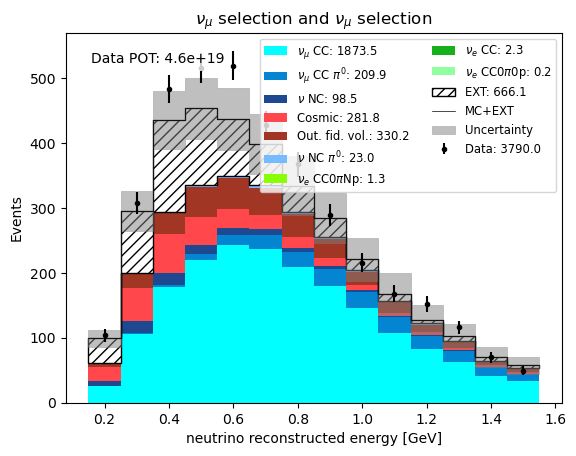

In [24]:
plotter = RunHistPlotter(numu_generator, selection_title=None)
plotter.plot(add_ext_error_floor=False, category_column="category", include_multisim_errors=True, add_precomputed_detsys=True)

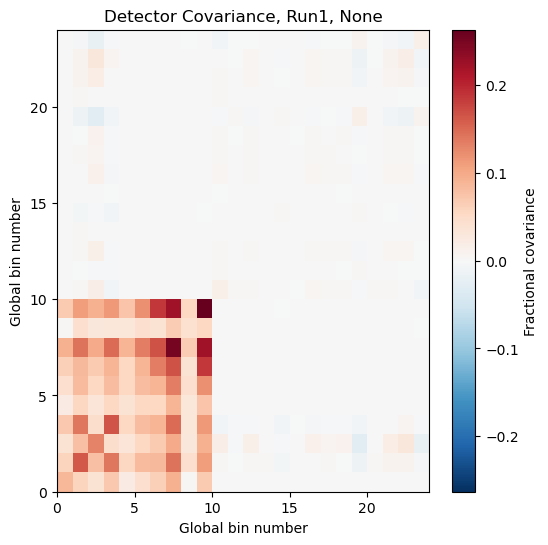

In [27]:
hist_gen_1 = signal_generator.mc_hist_generator
hist_gen_2 = numu_generator.mc_hist_generator

combined_covariance = HistogramGenerator.multiband_detector_covariance([hist_gen_1, hist_gen_2])

combined_binning = MultiChannelBinning([hist_gen_1.binning, hist_gen_2.binning])
hist_1 = hist_gen_1.generate()
hist_2 = hist_gen_2.generate()
concatenated_bin_counts = np.concatenate([hist_1.nominal_values, hist_2.nominal_values])
# plot covariance using a temporary histogram object as we did above
fig, ax = plt.subplots(figsize=(6, 6))
tmp_histogram = MultiChannelHistogram(combined_binning, concatenated_bin_counts, covariance_matrix=combined_covariance)
tmp_histogram.draw_covariance_matrix(as_correlation=False, as_fractional=True, ax=ax)
ax.set_title(f"Detector Covariance, Run1, {plotter.title}")
fig.savefig("detector_correlation_run1_nuebdt_numu.pdf")

In [22]:
hist_gen_2.detvar_data